## Metoda "korak po korak" za analizu dinamičke stabilnosti

M. i K. Ožegović, ELEKTRIČNE MREŽE III, Sveučilište u Splitu, FESB, Split, 1982.

Rješenje za Primjer 1.10  (str. 101).

Tablica 1.1 (str. 102) je za Pm=0.8 i uspješan APU.

![Primjer 1.10](slike/primjer_1_10.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Figure aesthetics.
import seaborn as sns
sns.set_theme(context='paper', style='white', font_scale=1.1)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})


In [3]:
def korak_po_korak(H, Po, Pkv, Piv, Pnp, 
                   t_isk, APU_postoji, APU_uspjesan, tAPU, 
                   tmax, dt, EPS=1e-3):
    """
    Metoda "korak po korak" za proracun dinamicke stabilnosti.

    Numericki proracun dinamicke stabilnosti jednostavnog EES-a
    pomocu metode korak po korak. Razmatra se nastup bilo koje
    vrste kratkog spoja (K3, K2, K1, K2Z) na jednom od dva
    paralelna voda kojim je elektrana (generator i blok trans-
    formator) prikljucena na mrezu. Moguce je pritom dodatno
    uzeti u obzir djelovanje APU-a (tropolni) koji moze biti
    uspjesan ili neuspjesan.

    Arguments
    ---------
    H: float
        Konstanta inercije rotirajucih masa (MWs/MVA).
        Turbogeneratori: 5 - 8
        Hidrogeneratori: 2.5 - 4
        Sinhr. kompenz.: 1.25 - 2
    Po: float
        Mehanicka snaga u jed. vr.
    Pkv: float 
        Tjemena vrijednost snage prijenosa za vrijeme trajanja 
        kratkog spoja u jed. vr. 
    Piv: float
        Tjemena vrijednost snage prijenosa jednog voda u pogonu u jed. vr.
    Pnp: float
        Tjemena vrijednost snage prijenosa normalnog pogona (kada su oba 
        voda u pogonu) u jed. vr.
    t_isk: float
        Vrijeme odgode iskljucenja kvara (s).
    APU_postoji: bool
        Indikator postojanja (True) ili nepostojanje (False) 
        automatskog ponovnog uklopa na vodu. Rijec je o tropolnom APU
        kod kojeg se jedan vod (na kojem je bio kvar) stavlja izvan pogona.
    APU_uspjesan: bool
        Indikator uspjesnog (True) ili neuspjesnog (False) djelovanja
        APU-a, tj. indikator nestanka kvara nakon isteka beznaponske pauze. 
        Ako je APU bio neuspjesan, dolazi do ponovnog ukljucenja voda na 
        kvar i konacnog potom iskljucenja s vremenskom pauzom za koju se 
        pretpostavlja da ima istu vrijednost kao i originalno vrijeme 
        odgode iskljucenja kvara.
    tAPU: float
        Vrijeme trajanja beznaponske pauze APU-a (s).
    tmax: float
        Ukupno vrijeme promatranja dinamicke stabilnosti (s).
    dt: float
        Vremenski korak proracuna (s). Mora biti visekratnik
        vremena iskljucenja kvara (i vremena trajanja APU-a).
    EPS: float, default=1e-3
        Tolerancija za odredjivanje vremena iskljucenja kvara i
        vremena trajanja APU-a.
    
    Returns
    -------
    t: np.array
        Vrijeme (s).
    d: np.array
        Kut opterecenja (stupnjevi).
    
    Napomena
    --------
    Jedinicne vrijednosti snaga Po, Pkv, Piv, Pnp zadaju se u odnosu na
    nazivnu snagu generatora (Sn = 1).

    Literatura
    ----------
    M. i K. Ožegović, ELEKTRIČNE MREŽE III, Sveučilište u Splitu, 
    FESB, Split, 1982.
    """
    if t_isk <= 0:
        raise ValueError('Vrijeme iskljucenja kvara ne moze biti nula.')
    if APU_postoji and tAPU <= 0:
        raise ValueError('Beznaponska pauza APU ne moze biti nula.')
    if APU_postoji and tmax < t_isk + tAPU:
        raise ValueError('Vrijeme promatranja pojave je prekratko postavljeno.')
    if APU_postoji is False and tmax < t_isk:
        raise ValueError('Vrijeme promatranja pojave je prekratko postavljeno.')

    # Konstante proracuna.
    Sn = 1.0  # p.u.
    k = 9000./(H*Sn)
    rad = np.pi/180.

    # Inicijalni kut operecenja.
    do = np.arcsin(Po/Pnp)*180./np.pi

    # Alociranje memorije.
    N = int(tmax/dt) + 1
    t = np.arange(N)*dt    # vrijeme
    dd = np.empty_like(t)  # delta delta
    d = np.empty_like(t)   # delta
    
    # Kvar nastupa u pocetnom trenutku (t = 0 s).
    # Pocetni trenutak.
    Pe = Pkv * np.sin(do*rad)
    alpha = k * (Po - Pe)
    omega = alpha * dt/2.
    dd[0] = omega * dt/2. + alpha * (dt/2.)**2
    d[0] = do + dd[0]

    if APU_postoji:
        # Postoji APU na vodu.
        for i in range(1, N):
            # Za vrijeme trajanja kratkog spoja.
            if t[i] < t_isk:
                Pe = Pkv * np.sin(d[i-1]*rad)
                alpha = k * (Po - Pe)
                dd[i] = dd[i-1] + alpha * dt**2
                d[i] = d[i-1] + dd[i]
            elif abs(t[i] - t_isk) <= EPS:
                # Trenutak iskljucenja kratkog spoja.
                Pe1 = Pkv * np.sin(d[i-1]*rad)
                Pe2 = Piv * np.sin(d[i-1]*rad)
                dp1 = Po - Pe1
                dp2 = Po - Pe2
                dp = (dp1 + dp2)/2.
                alpha = k * dp
                dd[i] = dd[i-1] + alpha * dt**2
                d[i] = d[i-1] + dd[i]
            elif t_isk < t[i] < t_isk + tAPU:
                # Nakon iskljucenja voda u kvaru (tece beznaponska
                # pauza ako postoji APU).
                Pe = Piv * np.sin(d[i-1]*rad)
                alpha = k * (Po - Pe)
                dd[i] = dd[i-1] + alpha * dt**2
                d[i] = d[i-1] + dd[i]
            elif abs(t[i] - (t_isk + tAPU)) <= EPS:
                # Trenutak isteka beznaponske pauze APU-a.
                if APU_uspjesan:
                    # APU je uspjesan.
                    Pe1 = Piv * np.sin(d[i-1]*rad)
                    Pe2 = Pnp * np.sin(d[i-1]*rad)
                    dp1 = Po - Pe1
                    dp2 = Po - Pe2
                    dp = (dp1 + dp2)/2.
                    alpha = k * dp
                    dd[i] = dd[i-1] + alpha * dt**2
                    d[i] = d[i-1] + dd[i]
                else:
                    # APU je neuspjesan.
                    Pe1 = Piv * np.sin(d[i-1]*rad)
                    Pe2 = Pkv * np.sin(d[i-1]*rad)
                    dp1 = Po - Pe1
                    dp2 = Po - Pe2
                    dp = (dp1 + dp2)/2.
                    alpha = k * dp
                    dd[i] = dd[i-1] + alpha * dt**2
                    d[i] = d[i-1] + dd[i]
            elif t[i] > t_isk + tAPU:
                # Nakon vremena isteka beznaponske pauze.
                if APU_uspjesan:
                    # APU je uspjesan.
                    # Sustav se vraca u normalno pogonsko stanje.
                    Pe = Pnp * np.sin(d[i-1]*rad)
                    alpha = k * (Po - Pe)
                    dd[i] = dd[i-1] + alpha * dt**2
                    d[i] = d[i-1] + dd[i]
                else:
                    # APU je neuspjesan.
                    if t_isk + tAPU < t[i] < t_isk + tAPU + t_isk:
                        # Ponovno ukljucenje na kvar do konacnog iskljucenja.
                        # Pretpostavlja se da je odgoda iskljucenja kvara 
                        # nakon neuspjesnog APU-a ista kao i kod prvog 
                        # djelovanja relejne zastite.
                        Pe = Pkv * np.sin(d[i-1]*rad)
                        alpha = k * (Po - Pe)
                        dd[i] = dd[i-1] + alpha * dt**2
                        d[i] = d[i-1] + dd[i]
                    else:
                        # Konacno iskljucenje kvara nakon neuspjesnog APU-a.
                        # Sustav nastavlja pogon samo s jednim vodom.
                        Pe = Piv * np.sin(d[i-1]*rad)
                        alpha = k * (Po - Pe)
                        dd[i] = dd[i-1] + alpha * dt**2
                        d[i] = d[i-1] + dd[i]
    else:
        # APU ne postoji.
        for i in range(1, N):
            if t[i] < t_isk:
                # Za vrijeme trajanja kratkog spoja.
                Pe = Pkv * np.sin(d[i-1]*rad)
                alpha = k * (Po - Pe)
                dd[i] = dd[i-1] + alpha * dt**2
                d[i] = d[i-1] + dd[i]
            elif abs(t[i] - t_isk) <= EPS:
                # Trenutak iskljucenja kratkog spoja.
                Pe1 = Pkv * np.sin(d[i-1]*rad)
                Pe2 = Piv * np.sin(d[i-1]*rad)
                dp1 = Po - Pe1
                dp2 = Po - Pe2
                dp = (dp1 + dp2)/2.
                alpha = k * dp
                dd[i] = dd[i-1] + alpha * dt**2
                d[i] = d[i-1] + dd[i]
            else:
                # Nakon iskljucenja voda u kvaru.
                # Sustav nastavlja pogon samo s jednim vodom.
                Pe = Piv * np.sin(d[i-1]*rad)
                alpha = k * (Po - Pe)
                dd[i] = dd[i-1] + alpha * dt**2
                d[i] = d[i-1] + dd[i]
    
    return (t, d)

### Primjer 1.10

In [4]:
# Ozegovic, Elektricne mreze III, Primjer 1.10, str. 101.
# Ulazni podaci:
H = 3.

# Tjemene vrijednosti snaga:
Po = 0.8     # Mehanicka snaga jed.vr.
Pk3 = 0.302  # Snaga tropolnog kratkog spoja jed.vr.
Piv = 1.129  # Snaga nakon iskljucenja kvara jed.vr.
Pnp = 1.368  # Snaga normalnog pogona jed.vr.

t_isk = 0.15  # Vrijeme iskljucenja kvara.
APU_postoji = True  # APU postoji (True) ili ne postoji (False).
APU_uspjesan = True # APU uspjesan (True) ili neuspjesan (False).
tAPU = 0.4   # Vrijeme trajanja beznaponske pauze APU.
tmax = 0.7  # Vrijeme promatranja dinamicke stabilnosti.
dt = 0.05    # Vremenski korak proracuna.

#### Dalekovod ima APU koji je uspješan.

![APU uspjesno](slike/APU_uspjesno.png)

In [5]:
# Osnovna varijanta (APU uspjesno).
t, d = korak_po_korak(H, Po, Pk3, Piv, Pnp, t_isk, 
                      APU_postoji, APU_uspjesan, tAPU, tmax, dt)

In [6]:
# Usporediti s rezultatima u Tablici 1.1 (str. 102).
print(d.round(2))

[38.13 45.07 56.4  69.27 80.21 88.82 94.95 98.66 99.99 98.98 95.6  88.91
 77.96 62.98]


#### Dalekovod ima APU koji je neuspješan.

![APU neuspjesno](slike/APU_neuspjesno.png)

In [7]:
APU_uspjesan = False  # Varijanta: APU je neuspjesno.
t, d_neuspjeh = korak_po_korak(H, Po, Pk3, Piv, Pnp, t_isk, 
                               APU_postoji, APU_uspjesan, tAPU, tmax, dt)

#### Dalekovod nema APU.

![APU ne postoji](slike/APU_ne_postoji.png)

In [8]:
APU_postoji = False  # Varijanta: Dalekovod nema APU.
t, d_noAPU = korak_po_korak(H, Po, Pk3, Piv, Pnp, t_isk, 
                            APU_postoji, APU_uspjesan, tAPU, tmax, dt)

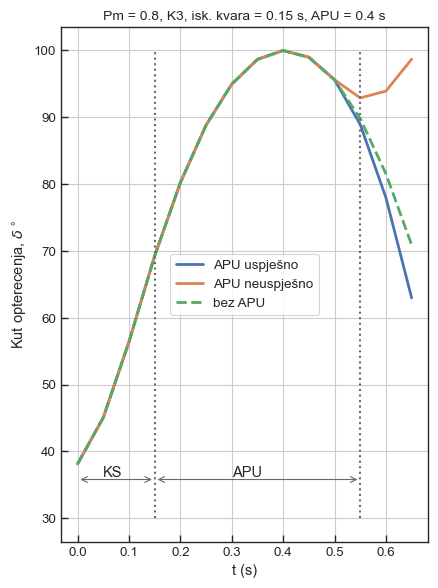

In [9]:
# Ozegovic, Elektricne mreze III, Primjer 1.10, Slika 57, str. 107.
fig, ax = plt.subplots(figsize=(4.5,6))
ax.set_title(f'Pm = {Po}, K3, isk. kvara = {t_isk} s, APU = {tAPU} s', 
             fontdict={'size':10})
# Prikazi krivulje promjene kuta opterecenja.
ax.plot(t, d, lw=2, label='APU uspješno')
ax.plot(t, d_neuspjeh, lw=2, label='APU neuspješno')
ax.plot(t, d_noAPU, ls='--', lw=2, label='bez APU')
# Oznaci vremenske trenutke od interesa.
low, high = 30, 100
ax.vlines(t_isk, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
ax.vlines(t_isk+tAPU, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
do = np.arcsin(Po/Pnp)*180/np.pi
ax.annotate('KS', xy=(t_isk-0.1, do), va='bottom')
ax.annotate('', xy=(0, do), xytext=(t_isk, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
ax.annotate('APU', xy=(tAPU-0.1, do), va='bottom')
ax.annotate('', xy=(t_isk, do), xytext=(t_isk+tAPU, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
# Koordinatne osi i legenda.
ax.legend(loc='center')
ax.set_xlabel('t (s)')
ax.set_ylabel('Kut opterecenja, ' + r'$\delta \, ^{\circ}$')
ax.grid(visible=True, which='major', axis='both')
fig.tight_layout()
plt.show()